# 2nd Level Model Structure: Condenser Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.model_utility import add_dual, update_dual, check_DOF
from utility.display_utility import trans_product_mole, trans_product_mass

# stage construction rules
from physics.energy_condenser import energy_block_rule
from physics.VLLE_condenser import VLLE_block_rule

# collect variable bounds
from physics.bounds import water_x, water_yp

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet
model.COMP_WATER = pe.Set(initialize=['H2O'])

# Global Variables

In [4]:
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(20+273.15,40+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar
model.Q_main = pe.Var(within=pe.Reals) # MW
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.W = pe.Var(within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)

model.H_F = pe.Var(within=pe.Reals)
model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

# Construct Individual Blocks

In [5]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [6]:
model.VLE_block = pe.Block(rule=VLLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [7]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    elif i in model.COMP_WATER:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) - model.W == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [8]:
# Equilibrium
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL-model.COMP_WATER,rule=VL_equil_rule)

# Water phase
def L_water_rule(model,i):
    return model.x[i] == pe.exp(-0.66037 - 7.1130*(539.1/model.T) - 0.67885*(1-model.T/539.1)**(1/3) -1.43381*(1-model.T/539.1))
model.L_water_con = pe.Constraint(model.COMP_WATER,rule=L_water_rule)

def V_water_rule(model,i):
    return model.y[i]*model.P == pe.exp(2.30258509299*(5.20389 - 1733.926/(model.T-39.485)))
model.V_water_con = pe.Constraint(model.COMP_WATER,rule=V_water_rule)

In [9]:
# add bounds specifically for water
model.x['H2O'].setub(water_x[1]+abs(water_x[1])*0.1)
model.x['H2O'].setlb(water_x[0]-abs(water_x[0])*0.1)

model.y['H2O'].setub(water_yp[1]/model.P.lb)
model.y['H2O'].setlb(water_yp[0]/model.P.ub)

## Summation

\begin{equation}
\sum_ix_{i} = 1 \\
\sum_iy_{i} = 1
\end{equation}

In [10]:
def summation_x_main_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == 1
model.summation_x_main_con = pe.Constraint(rule=summation_x_main_rule)

def summation_y_main_rule(model):
    return sum(model.y[i] for i in m.COMP_TOTAL) == 1
model.summation_y_main_con = pe.Constraint(rule=summation_y_main_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [11]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) - model.W*model.energy_block.dH_L['H2O'] == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [12]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Load a sample vapor feed from reactive flash example

In [13]:
with open('../saved_solutions/reactive_flash_200C_n20.pickle', 'rb') as f:
    C200 = pickle.load(f)

## Fixing In/Product Redundent Flow

In [14]:
model.x_.fix(0)
for i in m.COMP_TOTAL:
    model.y_['in',i].fix(C200.Solution.Variable['y[{}]'.format(i)]['Value'])
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(1)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(C200.Solution.Variable['H_V']['Value'])

## Fixing Model Parameters

In [15]:
model.P.fix(19)
model.T_F.fix(200+273.15)
model.F.fix(0)
model.z['CO'].fix(0.3333)
model.z['H2'].fix(0.6666)
model.z['C30H62'].fix(0.0001)
model.VLE_block.n_ave.fix(4)

In [16]:
check_DOF(pe,model)

Active Equality Constraints:	 957
Active Inequality Constraints:	 0
Active Variables:		 1129
Fixed Variables:		 171
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [17]:
model.T.setub(40+273.15)

In [18]:
model.obj = pe.Objective(expr = model.T,sense=pe.maximize)

In [19]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0

opt.options['halt_on_ampl_error'] = 'yes'
opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
halt_on_ampl_error=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma86                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:     3068
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in 

 112 -3.0307067e+02 1.66e-01 5.14e+06  -1.0 4.39e+02    -  6.15e-01 4.24e-02f  4
 113 -3.0340286e+02 1.72e-01 5.32e+06  -1.0 2.84e+02    -  9.42e-01 4.62e-02f  4
 114 -3.0386713e+02 1.72e-01 4.49e+06  -1.0 1.13e+02    -  1.00e+00 1.63e-01f  3
 115 -3.0460026e+02 1.97e-01 1.04e+05  -1.0 2.92e+01    -  1.00e+00 1.00e+00f  1
 116 -3.0510515e+02 2.98e-01 1.74e+06  -1.0 4.39e+02    -  3.70e-01 4.58e-02f  1
 117 -3.0577361e+02 2.46e-01 4.22e+05  -1.0 6.38e+01    -  1.00e+00 4.19e-01f  1
 118 -3.0586980e+02 2.36e-01 4.40e+05  -1.0 6.74e+01    -  1.40e-01 5.74e-02h  1
 119 -3.0671127e+02 9.62e-02 3.40e+03  -1.0 3.39e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 -3.0744939e+02 1.52e-01 4.42e+06  -2.5 2.06e+02    -  5.99e-01 1.44e-01f  1
 121 -3.0998035e+02 8.61e-01 9.41e+05  -2.5 1.03e+02    -  9.41e-01 1.00e+00f  1
 122 -3.1314104e+02 1.39e+00 3.78e+04  -2.5 1.33e+02    -  1.00e+00 9.87e-01f  1
 123 -3.1314998e+02 1.39e+00

In [20]:
model.Q_main.value

-11.309573060309324

In [21]:
model.T.value

313.15

In [22]:
# model.solutions.store_to(results)
# with open('../saved_solutions/condenser_40C.pickle','wb') as f:
#     pickle.dump(results,f)

In [23]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0056			Vapor: 0.8725			log K
------------------------------------------------------------------------------------------------------------
H2         		 0.3944%			28.6968%			1.8619
CO         		 0.9344%			32.7414%			1.5446
CO2        		 6.5403%			36.9600%			0.7521
H2O        		 0.0001%			 0.3883%			3.6757
C2H4       		 0.0377%			 0.1360%			0.5576
C3H6       		 0.2099%			 0.1548%			-0.1322
C4H8       		 0.5519%			 0.1354%			-0.6102
C5H10      		 1.2771%			 0.0982%			-1.1141
C6H12      		 3.0741%			 0.0776%			-1.5979
C7H14      		 5.8606%			 0.0500%			-2.0689
C8H16      		 8.2399%			 0.0243%			-2.5311
C9H18      		 8.8476%			 0.0091%			-2.9868
C10H20     		 7.9886%			 0.0029%			-3.4377
C11H22     		 4.1442%			 0.0005%			-3.8847
C12H24     		 3.1449%			 0.0001%			-4.3287
C13H26     		 2.2610%			 0.0000%			-4.7702
C14H28     		 1.5577%			 0.0000%			-5.2096
C15H30     		 1.0391%			 0.0000%			-5.6472
C16H32     		 0.6772%			 0.0000%			-6.0833
C17H34     		 0.4345%			 0.00

# Iterative Solve for Data Analysis

In [24]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [25]:
cd_data = {}
cd_data['x'] = {}; cd_data['T'] = []; cd_data['Q'] = []; cd_data['V'] = []; cd_data['L'] = []; 

for i in m.COMP_TOTAL:
    cd_data['x'][i] = []
    
Trange = np.arange(40+273.15,19+273.15,-2)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {} K'.format(model.T.value))
    # print('-'*72)
    cd_data['T'].append(model.T.value)
    cd_data['Q'].append(model.Q_main.value)
    cd_data['V'].append(model.V['out'].value)
    cd_data['L'].append(model.L['out'].value)    

    for i in m.COMP_TOTAL:
        cd_data['x'][i].append(model.x[i].value*model.L['out'].value)

Solved, Solution T = 313.15 K
Solved, Solution T = 311.15 K
Solved, Solution T = 309.15 K
Solved, Solution T = 307.15 K
Solved, Solution T = 305.15 K
Solved, Solution T = 303.15 K
Solved, Solution T = 301.15 K
Solved, Solution T = 299.15 K
Solved, Solution T = 297.15 K
Solved, Solution T = 295.15 K
Solved, Solution T = 293.15 K


## Some Observations

* This system has multiple solution under same Q.
* The reaction rate peaks at ~530K, due to decreasing $\alpha$, increasing light component, uses up more feed.
* Note that when 'fully' utilizing catalyst, the system seems to always require cooling.

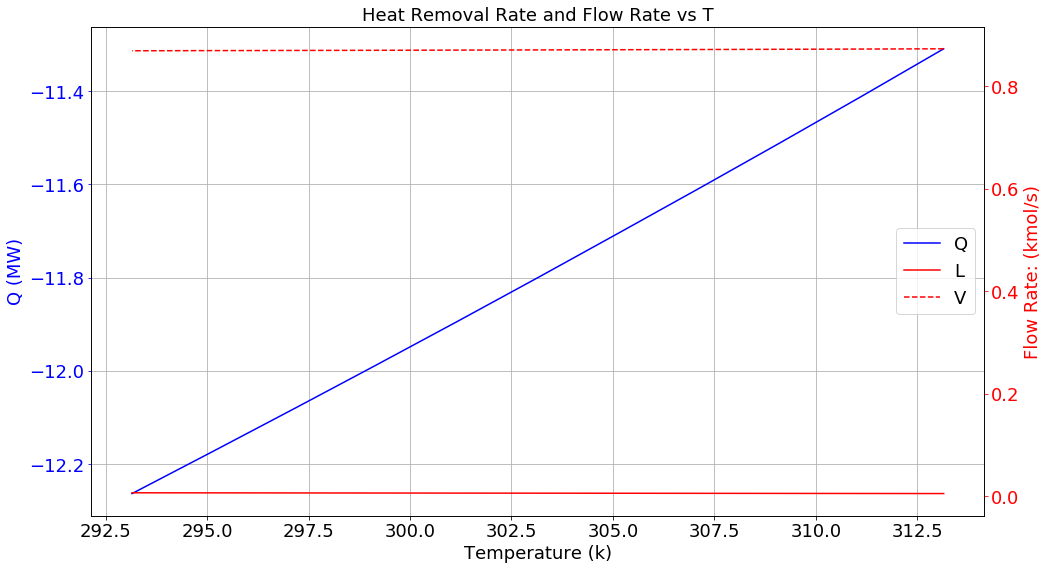

In [26]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(cd_data['T'],cd_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(cd_data['T'],cd_data['L'], 'r')
line3 = ax2.plot(cd_data['T'],cd_data['V'], 'r--')
ax2.set_ylabel('Flow Rate: (kmol/s)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3,['Q','L','V'],fontsize=18,loc=5)
ax1.set_title('Heat Removal Rate and Flow Rate vs T',fontsize=18)
plt.show()

## Product Distribution (mole)

In [27]:
reaction_data = trans_product_mole(cd_data['x'])['unscaled']
reaction_data_scaled = trans_product_mole(cd_data['x'])['scaled']

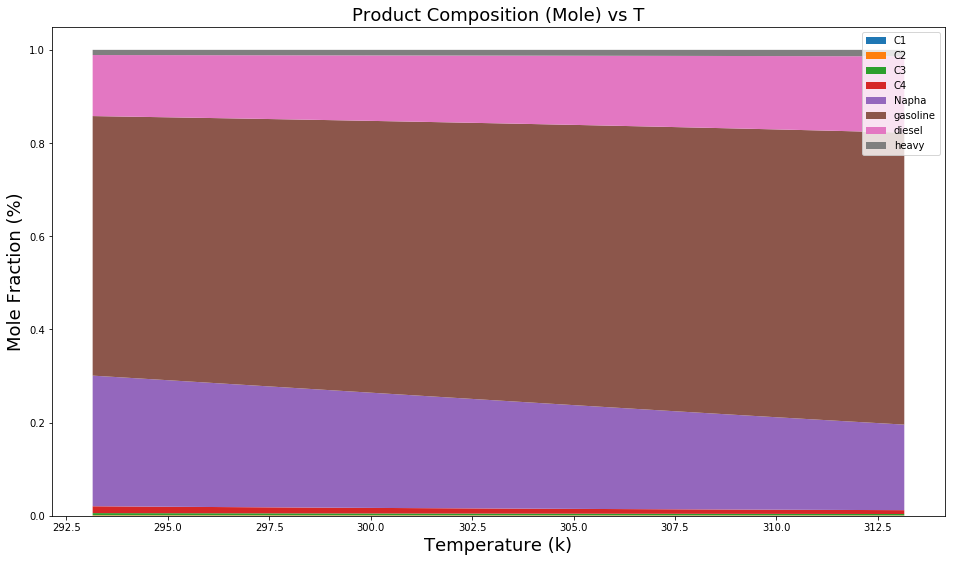

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

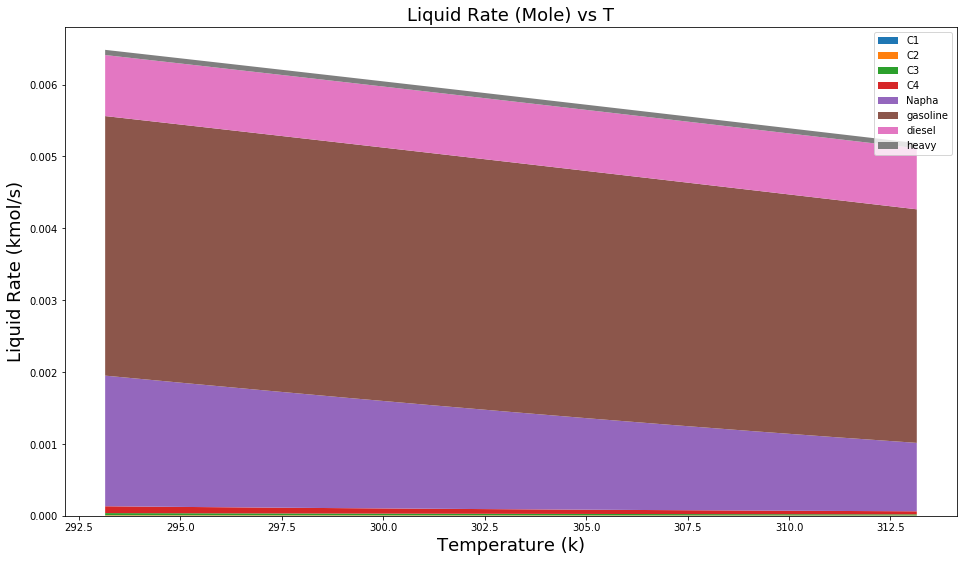

In [29]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Liquid Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Liquid Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

## Product Distribution (mass)

In [30]:
mass_reaction_data = trans_product_mass(cd_data['x'])['unscaled']
mass_reaction_scaled = trans_product_mass(cd_data['x'])['scaled']

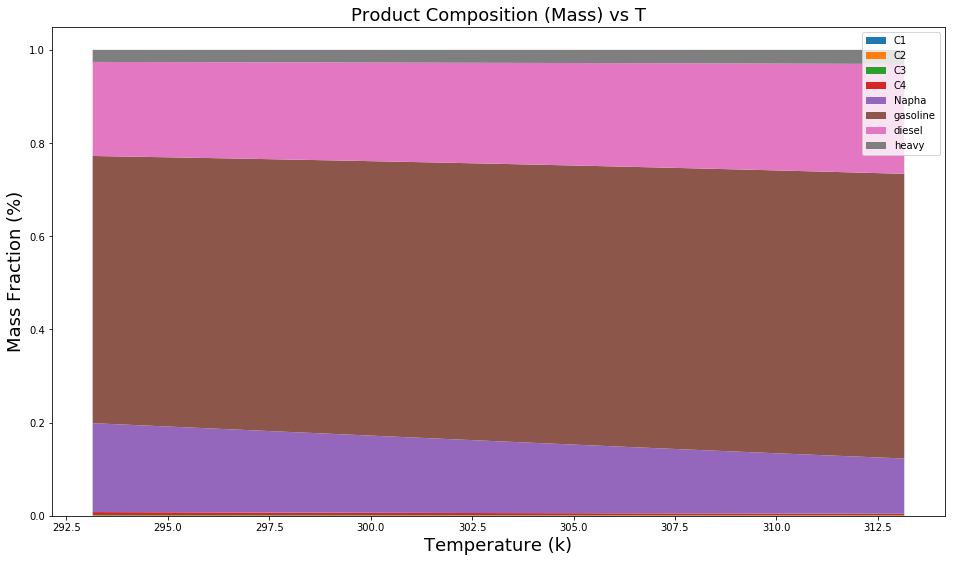

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

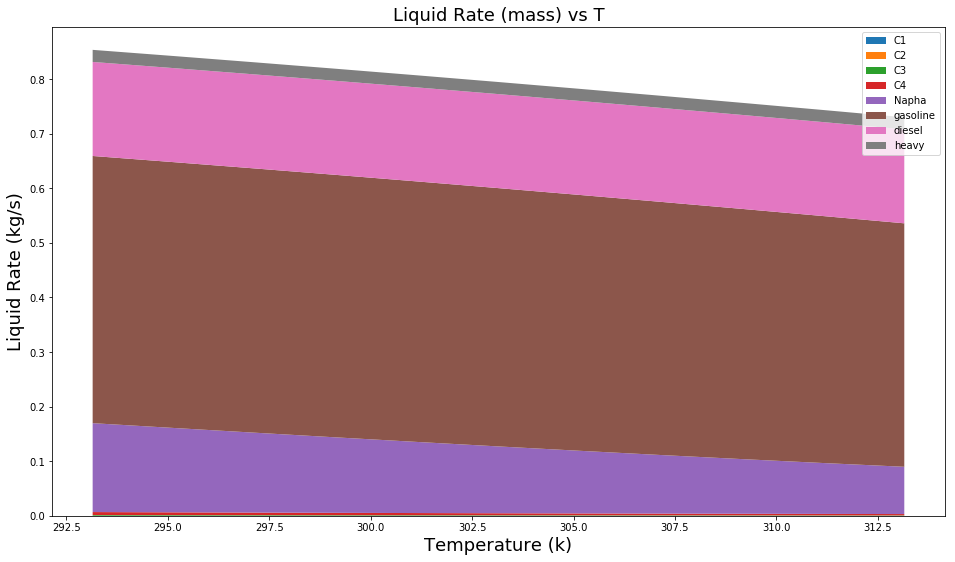

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(cd_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Liquid Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Liquid Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [33]:
# model.solutions.store_to(results)
# with open('../saved_solutions/condenser_20C.pickle','wb') as f:
#     pickle.dump(results,f)

In [34]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0071			Vapor: 0.8687			log K
------------------------------------------------------------------------------------------------------------
H2         		 0.3631%			28.8231%			1.8997
CO         		 0.9198%			32.8846%			1.5533
CO2        		 7.9955%			37.0999%			0.6665
H2O        		 0.0000%			 0.1229%			3.5684
C2H4       		 0.0487%			 0.1364%			0.4476
C3H6       		 0.3252%			 0.1542%			-0.3241
C4H8       		 0.9652%			 0.1317%			-0.8651
C5H10      		 2.3784%			 0.0873%			-1.4350
C6H12      		 5.2849%			 0.0544%			-1.9876
C7H14      		 7.8867%			 0.0233%			-2.5291
C8H16      		 8.5520%			 0.0074%			-3.0631
C9H18      		 7.8371%			 0.0020%			-3.5915
C10H20     		 6.5858%			 0.0005%			-4.1158
C11H22     		 3.3202%			 0.0001%			-4.6367
C12H24     		 2.4925%			 0.0000%			-5.1550
C13H26     		 1.7848%			 0.0000%			-5.6711
C14H28     		 1.2278%			 0.0000%			-6.1854
C15H30     		 0.8185%			 0.0000%			-6.6982
C16H32     		 0.5334%			 0.0000%			-7.2097
C17H34     		 0.3422%			 0.00

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


In [35]:
from utility.data_utility import cal_MW

In [36]:
liquid_MW = 0
for i in m.COMP_TOTAL:
    liquid_MW += model.x[i].value*cal_MW(i)

In [37]:
model.L['out'].value*liquid_MW

0.880356853527773

In [38]:
liquid_MW

123.19626367043564